# Time Series Analysis of Toronto Temperature Data
### Sebastian Lech
In this notebook I attempt to forecast the temperature in Toronto by fitting a time series model based on past temperature data (using R). Data is gathered from https://climate.weather.gc.ca/.  The analysis is meant to be carried out from the ground up, so I begin with collecting weather data, followed by a prelimenary examination of the data, then assessment of the nature of the time series, and finally forecast 80 days worth of temperatures and evaluate their accuracy.

### Sections
1. Gathering Data
2. Exploratory Analysis
3. Assessing Stationarity
4. Model Fitting
5. Forecasts

### Purpose
This purpose of this analysis is an exercise in model fitting; an application of the Box-Jenkins framework.  Weather in general is a very complex phenomena and to model it accurately requires a far more comprehensive report than what is delivered here.  Instead, this notebook focuses on the progression of a traditional Box-Jenkins analysis (which can be taken and applied to other ARMA models), and serves as a jumping off point for weather analysis.  

# 1. Gathering Data
Before we can perform any sort of analysis, we need data.  Luckily, the Government of Canada provides an abundance of temperature records for most major cities across Canada.  Data can be searched for at https://climate.weather.gc.ca/historical_data/search_historic_data_e.html which returns various weather metrics for stations located throughout a city.  In the case of Toronto, although there are many records, station data is rather unorganized and can range anywhere from hourly temperatures between 1953-1969 to monthly temperatures between 1840-2006.  Since a group of stations within particular region will not each have data for a specified timeframe we pick a single station and base our analysis using only its data.  Documenation on getting data is provided by the Government of Canada here https://drive.google.com/drive/folders/1WJCDEU34c60IfOnG4rv5EPZ4IhhW9vZH which contians a csv with geographical station information.  Since it contains daily data since 2002 and is close to downtown, we opt for the Toronto City station (ID: 31688) for our analysis

<!-- ![title](Rplot.png) -->
<img src="Rplot.png" alt="Drawing" style="width: 900px;"/>

The documentation located in the google drive above also provides a simple bash script to retrieve the weather data.  After a slight modification, the following can be used to gather the data:

```
#!/bin/bash
for year in `seq 2002 2021`
do
    wget -O "${year}_daily_temperature_31688.csv" "https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=31688&Year=${year}&Month=1&Day=14&timeframe=2&submit= Download+Data"
done

```
which will create 20 seperate csv files, each of whom contain daily weather data for their respectve year.  To avoid having to merge each file using R we can append their contents to a single file containing all year's data using shell
```
head -n 1 2002_daily_temperature_31688.csv > 2002_2021_daily_temps.csv && tail -n+2 -q *.csv >> 2002_2021_daily_temps.csv
```

# 2. Exploring Data
Now that we have temperature data we can begin to explore it.  Before we start, however, we should outline exactly how we plan to use the data.  Above we gathered roughly 20 years worth of data, which is a lot, and the steps of the analysis don't really change if we only had say, 5 years worth of data.  So, instead of using all the data, we will take the last 5 years and partition it into training/test sets (95/5 split), fit a model using the training set and then evaluate our forecasts using the test set.  

In [139]:
# some useful packages
library(ggplot2)
library(lubridate)
library(dplyr)
library(astsa)
library(TSA)
library(glue)
library(gdata)
library(tseries)
library(forecast)
library(Metrics)
library(gridExtra)
options(repr.plot.width=15, repr.plot.height=8)

In [56]:
stations <- read.csv('~/server/projects/time_series/toronto_temperatures/Station_Inventory_EN.csv', skip=2, header=TRUE)
TO_stations <- dplyr::filter(stations, grepl('TORONTO', Name))
names(TO_stations) <- c('Station', 'Province', 'Climate ID', 'Station ID', 'WMO ID', 'TC ID', 'Latitude.d', 'Longitude.d', 'Latitude', 'Longitude', 'Elevation', 'First Year', 'Last Year', 'HLY First Year', 'HLY Last Year', 'DLY First Year', 'DLY Last Year', 'MLY First Year', 'MLY Last Year')
station_coord <- select(TO_stations, 'Station', 'Province', 'Station ID', 'Latitude.d', 'Longitude.d', 'Elevation', 'First Year', 'Last Year')
head(station_coord)

,Station,Province,Station ID,Latitude.d,Longitude.d,Elevation,First Year,Last Year
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,PA TORONTO INTERNATIONAL TRAP AND SKEET,ONTARIO,52731,44.19,-79.66,234.5,2014,2015
2,PA TORONTO NORTH YORK MOTORS,ONTARIO,52678,43.72,-79.47,186.5,2014,2015
3,PA SCARBOROUGH TORONTO HUNT,ONTARIO,52641,43.68,-79.27,133.5,2014,2015
4,PA TORONTO HYUNDAI,ONTARIO,52640,43.70,-79.45,186.5,2014,2015
5,TORONTO,ONTARIO,5051,43.67,-79.40,112.5,1840,2017
6,TORONTO SOLAR RADIATION,ONTARIO,41863,43.67,-79.40,166.0,2018,2018


In [51]:
cities

City,Lat,Long,Pop
<chr>,<dbl>,<dbl>,<int>
Boston,42.3601,-71.0589,645966
Hartford,41.7627,-72.6743,125017
New York City,40.7127,-74.0059,8406000
Philadelphia,39.9500,-75.1667,1553000
Pittsburgh,40.4397,-79.9764,305841
Providence,41.8236,-71.4222,177994


In [62]:
leaflet(station_coord) %>% addTiles() %>%
  addCircles(lng = ~Longitude.d, lat = ~Latitude.d, weight = 1,
    radius = 500, popup = ~Station
  )

HTML widgets cannot be represented in plain text (need html)

In [83]:
weather_data <- read.csv('data/2002_2021_daily_temps.csv', header=TRUE)   # read data
names(weather_data)[c(1, 2, 10, 12, 14)] = c('longitude', 
                                             'latitude', 
                                             'max.temp', 
                                             'min.temp', 
                                             'mean.temp')
temp_data <- weather_data[c(5, 6, 7, 8, 10, 12, 14)] # only keep temperatures                   
temp_data$Date.Time <- as.Date(temp_data$Date.Time, format="%Y-%m-%d")  
temp_data$Month <- month.abb[temp_data$Month]
start <- as.Date('2017-01-01', format('%Y-%m-%d'))
end <- as.Date('2021-05-07', format('%Y-%m-%d'))
working_temps <- temp_data[temp_data[, 1] >= start & temp_data[, 1] <= end, ]

As with any datasets, there will be some inconsistencies in the data.  The first thing we want to check for is missing data.  Below we notice that there are 34 days missing mean temperatures, located throughout the data set.  Rather than manually looking up 34 seperate days from other sources of weather data we will linearly interpolate to fill in the blanks.

In [84]:
working_temps[!complete.cases(working_temps),] # identify missing (NA) mean temps

,Date.Time,Year,Month,Day,max.temp,min.temp,mean.temp
,<date>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>
5544,2017-03-06,2017,Mar,6,4.9,NA,NA
5580,2017-04-11,2017,Apr,11,NA,11.3,NA
5617,2017-05-18,2017,May,18,NA,18.4,NA
5621,2017-05-22,2017,May,22,NA,NA,NA
5622,2017-05-23,2017,May,23,21.8,NA,NA
5628,2017-05-29,2017,May,29,NA,14.7,NA
5637,2017-06-07,2017,Jun,7,NA,NA,NA
5782,2017-10-30,2017,Oct,30,NA,5.9,NA
5790,2017-11-07,2017,Nov,7,NA,4.0,NA


In [85]:
ndays <- length(working_temps$Year) # number of days, 1588
working_temps$mean.temp <- round(approx(1:ndays, working_temps$mean.temp, n=ndays)$y, 1) # linearly interpolate missing dates
split <- floor(ndays*0.95) 
train <- working_temps[1:split, ]   
test <- working_temps[(split+1):ndays, ]

### seasonality
Now we can take a look at the time series and how temperatures are distributed.  The first thing to notice from the time series is that there appears to be seasonality in the data.  Of course this makes sense given that we are looking at temperature data, however, there is some subtlety in what we are observing.  In the context time series analysis, seasonality refers to an autoregressive influence that occurs periodically.  For example, had we done this analysis on monthly data it would make sense that the temperature in Jan 2020 would be a good indicator of the temperature in Jan 2021, hence we would expect a season model whose autoregressive influence occurs every 12 months.  However, it does not seem reasonable to expect that the temperature on Jan 01, 2020 will be a good indicator of the temperature on Jan 01, 2021.  So, although general weather patterns exhibit seasonality, we do not fit a seasonal time series model. 

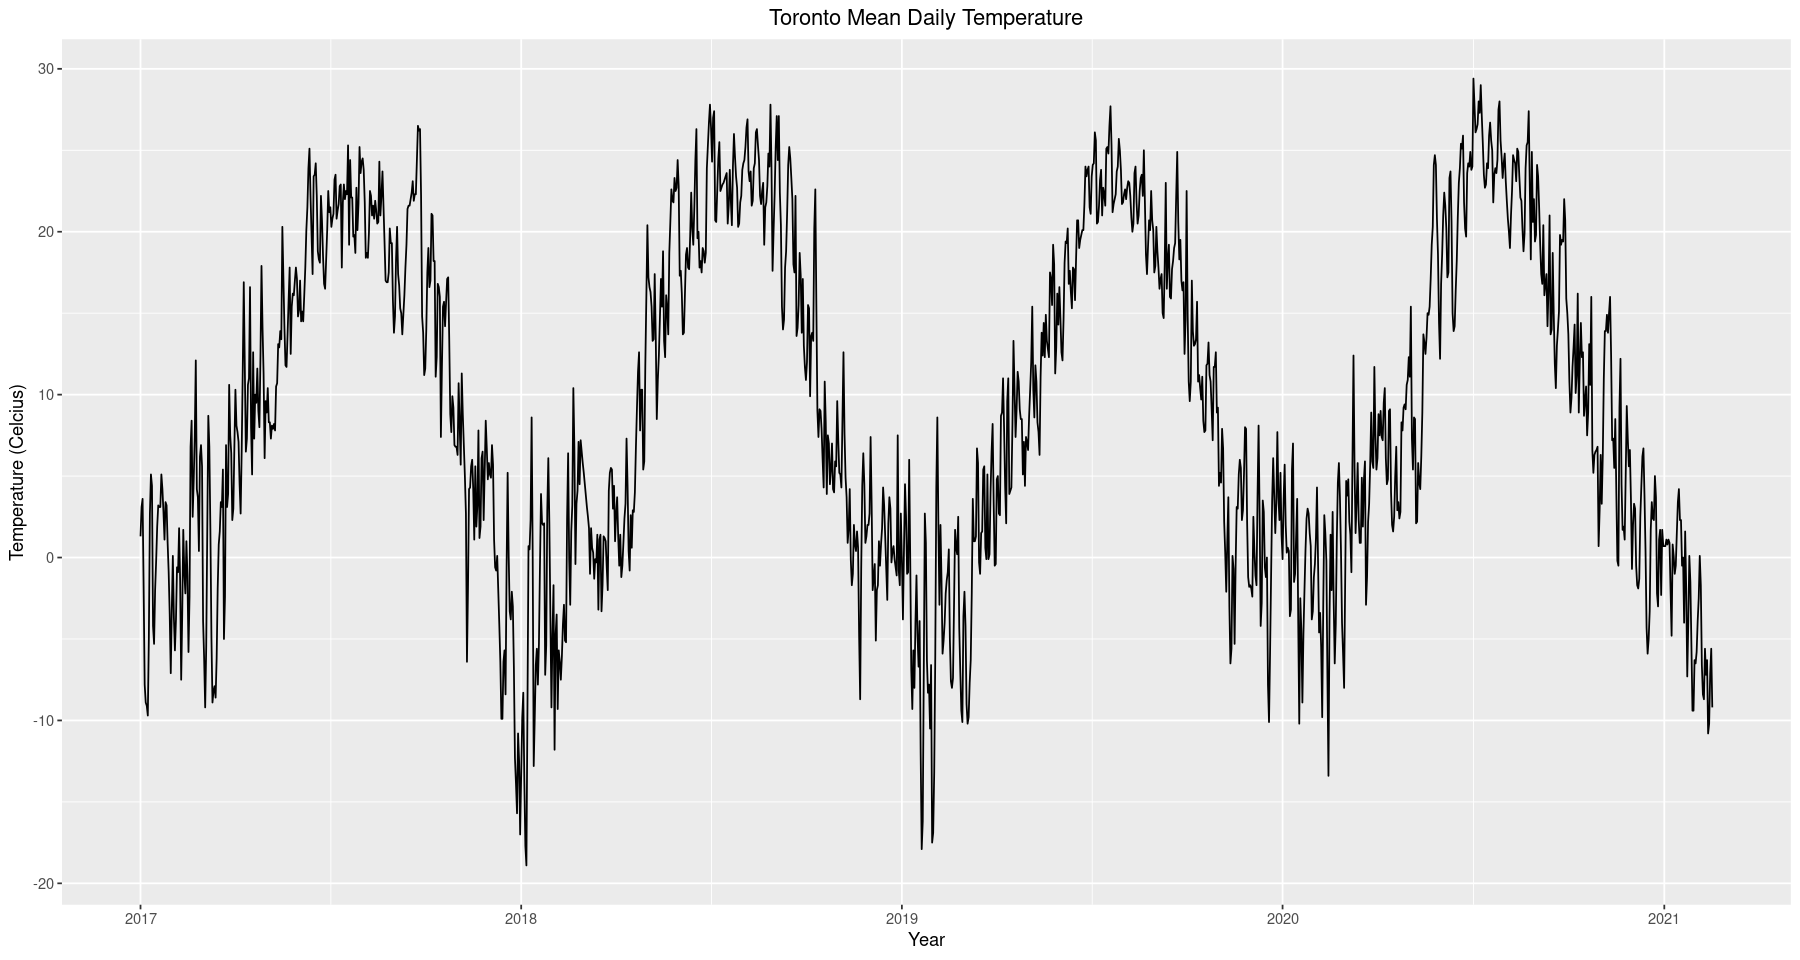

In [86]:
ggplot(data=train, aes(x=Date.Time, y=mean.temp)) + geom_line() +
        ggtitle('Toronto Mean Daily Temperature') + xlab('Year') + ylab('Temperature (Celcius)') +
        theme(plot.title = element_text(hjust = 0.5))

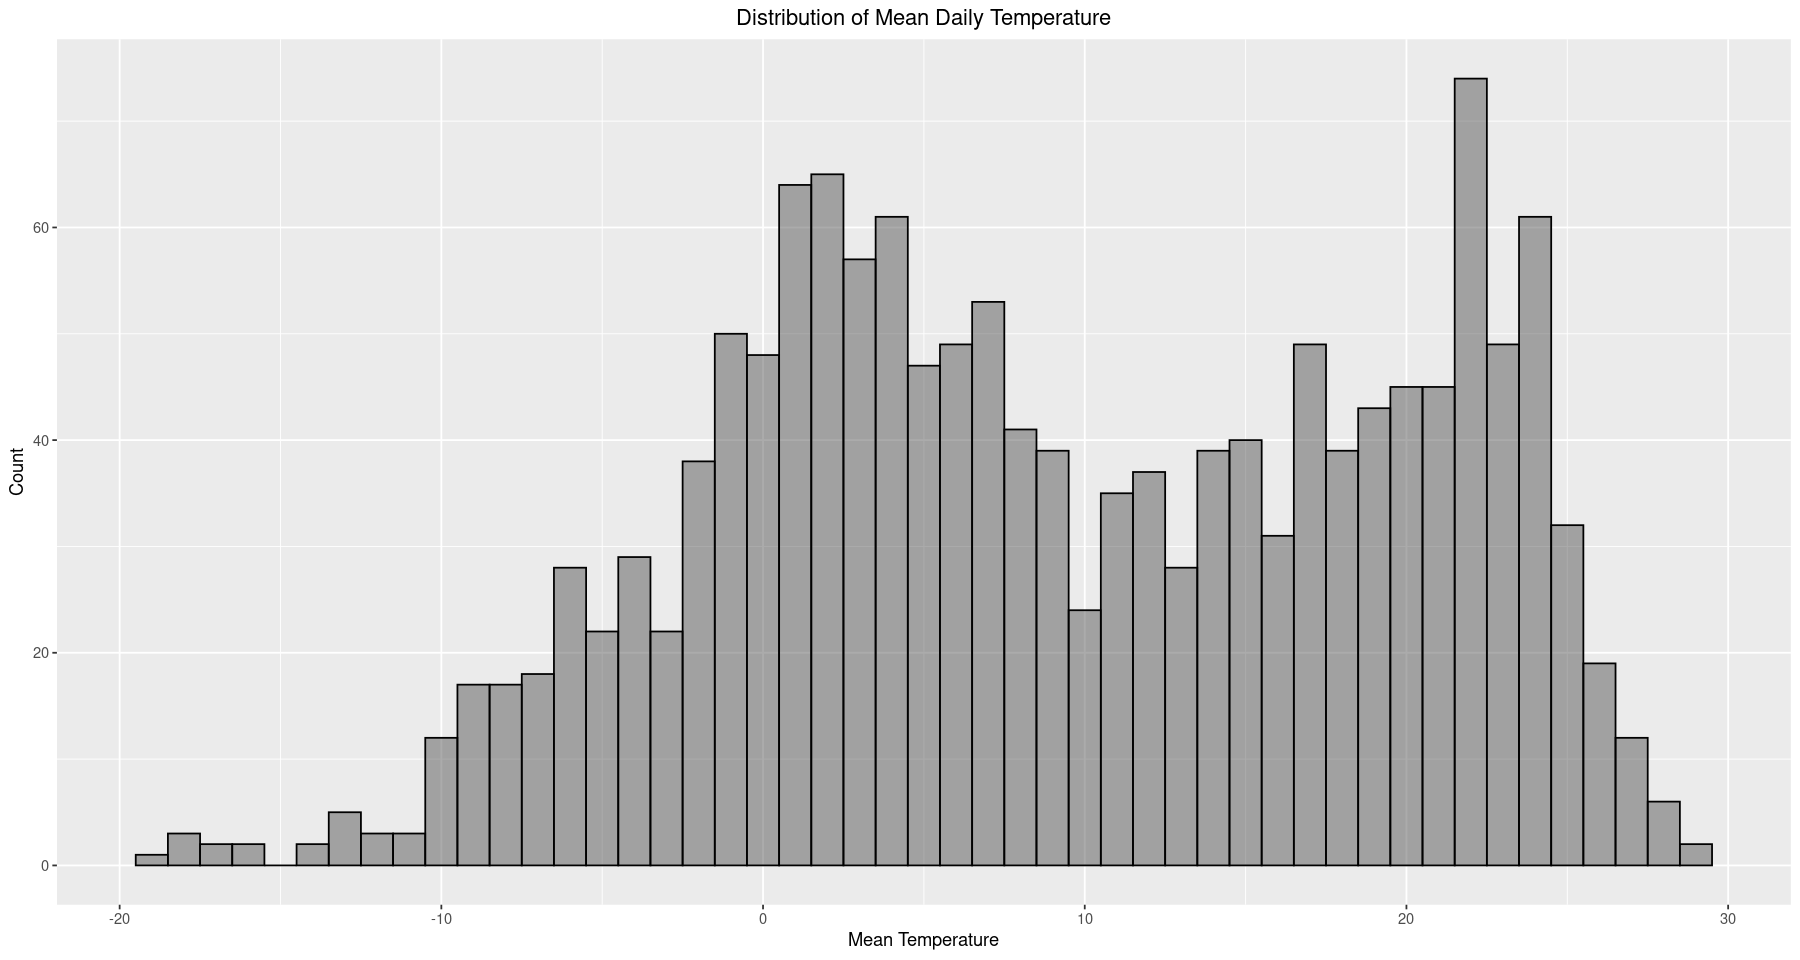

In [87]:
ggplot(data=train, aes(x=mean.temp)) + geom_histogram(binwidth=1, alpha=0.5, color='black') +
        ggtitle('Distribution of Mean Daily Temperature') + xlab('Mean Temperature') + ylab('Count') +
        theme(plot.title = element_text(hjust = 0.5))

The periodic nature of the data still presents a problem.  For instance, we see below that every year, between June and August, temperature will be a lot higher than in the other months.  Again, this is expected, since summer is the warmest time of the year, however it still presents a problem because we require stationary data in order to perform meaningful analysis.  Below we will confirm our suspicion that the data is not stationary and look at a way to remedy this issue.

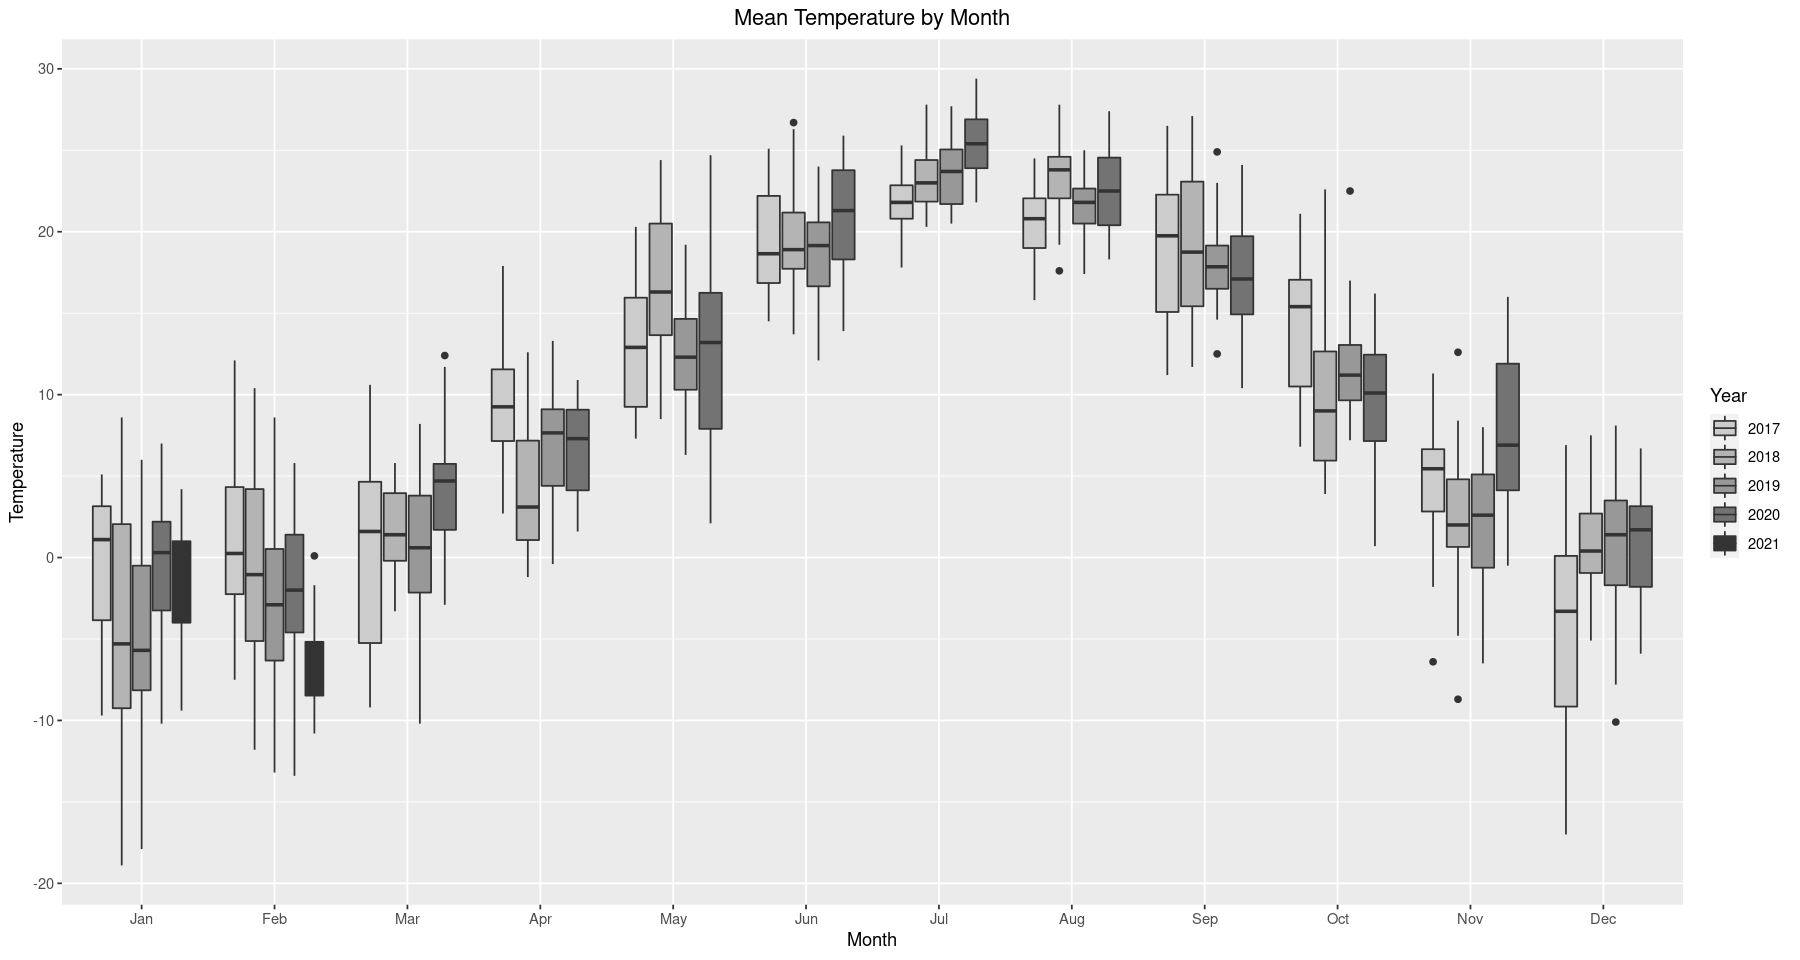

In [88]:
ggplot(train) + geom_boxplot(aes(y=mean.temp, 
                                         x=factor(Month, levels=month.abb), 
                                         fill=as.character(Year))) + scale_fill_grey(start = 0.8, end = 0.2) +
                        ylab('Temperature') + xlab('Month') + ggtitle('Mean Temperature by Month') +
                        theme(plot.title = element_text(hjust = 0.5)) + labs(fill='Year')

# 3. Assessing Stationarity
To assess stationarity, the first thing we want to look at is autocorrelation.  The ACF plot (top) decays very slowly and Partial ACF (bottom) has significant lags beyond what we would expect in stationary data.  Both plots exhibit strong indicators that the data is in fact, not stationary.  Likewise, we can employ the Augmented Dickey-Fuller (ADF) test to test if the data is stationary.  There is plenty of reason to think the data is not stationary, so we expect the ADF test to return an insignifcant result (since it tests the null hypothesis that the data is not stationary).  If this is the case, there is nothing concrete we can gather from the test (since it is insignificant) but given the nature of the data we will proceed in assuming nonstationarity and attempt to remedy this problem.

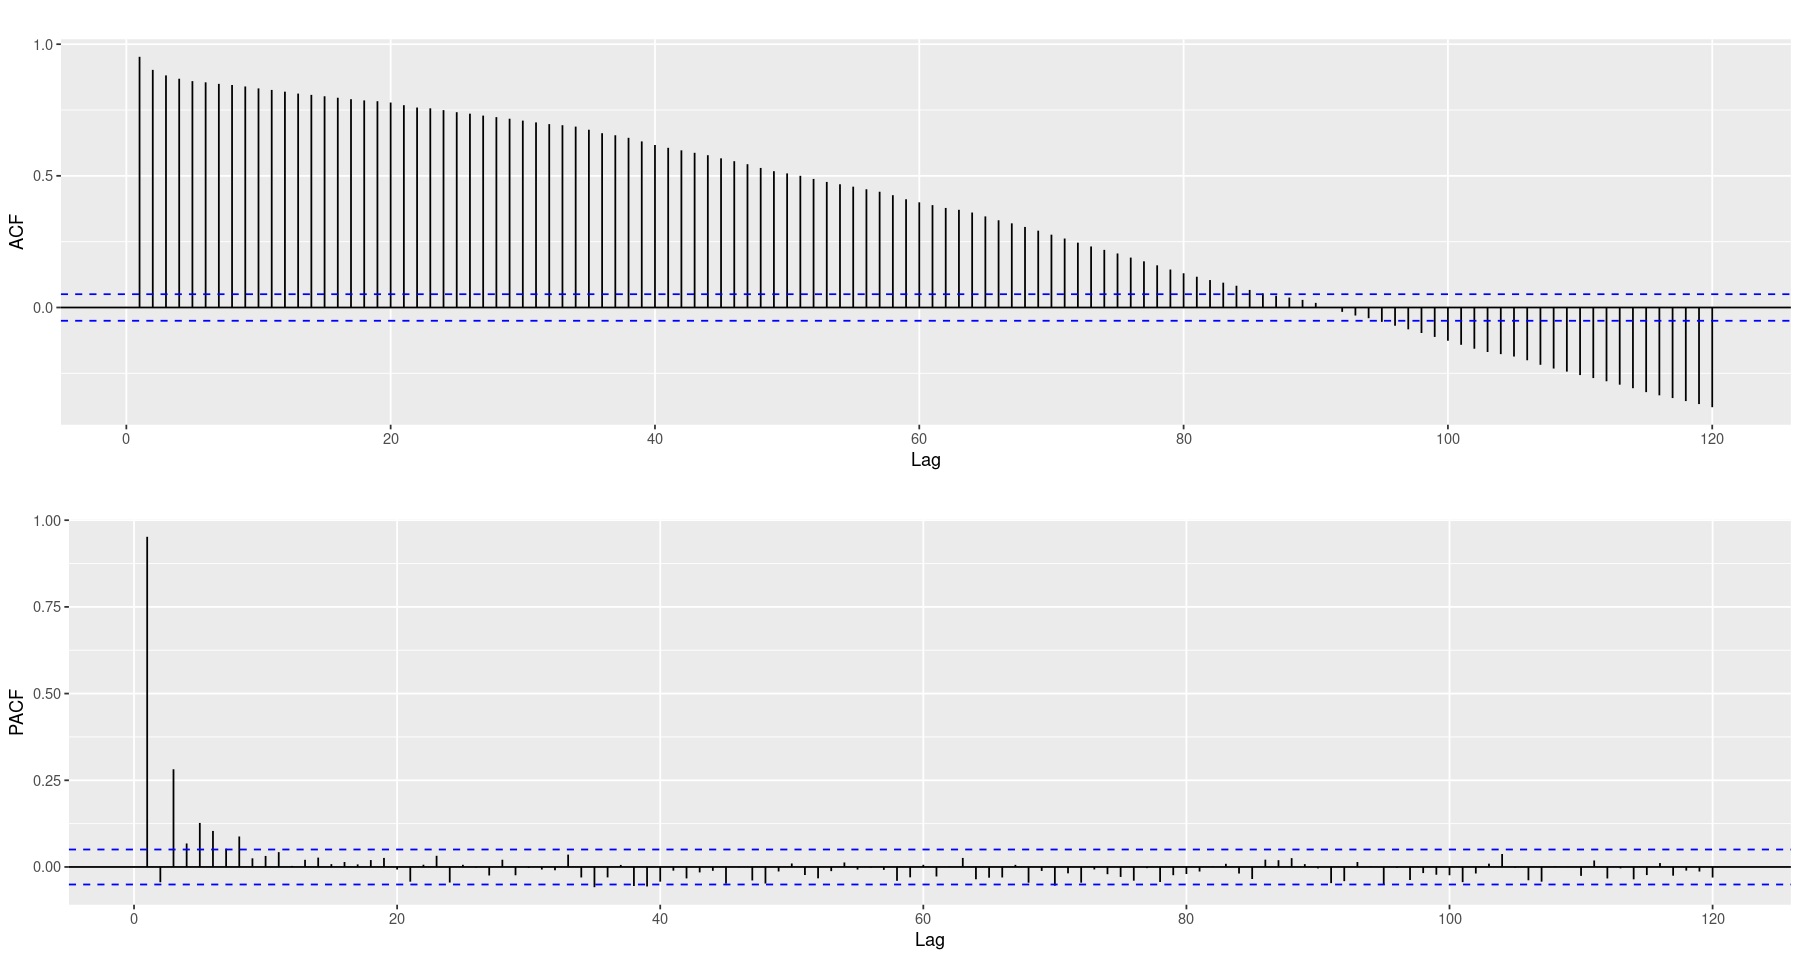

In [89]:
acf <- ggAcf(train$mean.temp, lag.max=120) + ggtitle('')
pacf <- ggPacf(train$mean.temp, lag.max=120) + ggtitle('')
grid.arrange(acf, pacf, nrow=2)

In [90]:
adf.test(train$mean.temp) 


	Augmented Dickey-Fuller Test

data:  train$mean.temp
Dickey-Fuller = -2.1489, Lag order = 11, p-value = 0.5153
alternative hypothesis: stationary


As we expected, the test is not significant.  So, up to this point we have no reason to believe the data might be stationary.  In order to apply the Box-Jenkins framework we need stationary data, which we attempt to extract in the section below. 

# 3. Model Fitting
We now discuss a potential model to fit our data.  We know that our data is not stationary, so to fix this we can extract a deterministic trend and then model the residual noise using Box-Jenkins.  Recall that the time series exhibits a periodic progression, 
which could be well modelled using a cosine curve.  In fact, we elect to model the deterministic trend using the following cosine model,

$$\mu_t = \beta \cos\left(\frac{2\pi t}{365} + \Phi\right)$$

Where 365 represents the period (yearly), $\beta$ the amplitude of the curve and $\Phi$ manages the origin of the curve. Fitting this curve is not straight forward becase the parameters we need to estimate (in particular, $\Phi$) do not enter the equation linearly.  However, we can take advantage of the following trigonometric identity 

$$\cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b)$$

That is, we take $a=2\pi t/365$ and $b=\Phi$ so that

$$\begin{align}
\beta \cos\left(\frac{2\pi t}{365} + \Phi\right) &= \beta \left(\cos\left(\frac{2\pi t}{365}\right)\cos\Phi - \sin\left(\frac{2\pi t}{365}\right)\sin\Phi\right) 
\end{align}$$
and let $\beta_1=\beta\cos\Phi$ and $\beta_2=-\beta\sin\Phi$.  Hence
$$\mu_t = \beta_1\cos\left(\frac{2\pi t}{365}\right) + \beta_2\sin\left(\frac{2\pi t}{365}\right)$$
Now notice that
$$\beta_1^2+\beta_2^2 = \beta^2(\cos^2\Phi+\sin^2\Phi) = \beta^2\iff \beta = \sqrt{\beta_1^2+\beta_2^2}$$
$$\frac{\beta_1}{\beta_2} = -\frac{\sin\Phi}{\cos\Phi} = -\tan(\Phi)\iff \Phi = \tan^{-1}\left(\frac{\beta_1}{\beta_2}\right)$$
which means we can determine $\mu_t$ by estimating $\beta_1, \beta_2$ using a linear regression 

In [153]:
temps_ts <- ts(train$mean.temp, start=c(2017, 1), f=365.25) # store as time series object
X <- harmonic(temps_ts, 1)    # matrix of predictor variables
x1 <- data.frame(X)$cos.2.pi.t      # predictor 1
x2 <- data.frame(X)$sin.2.pi.t      # predictor 2
cos_model <- lm(temps_ts ~ x1 + x2)
summary(cos_model)
train$cos_model <- as.double(fitted(cos_model))


Call:
lm(formula = temps_ts ~ x1 + x2)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.2120  -2.6323  -0.0664   2.8596  13.7209 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.8019     0.1063   92.19   <2e-16 ***
x1          -12.1171     0.1489  -81.37   <2e-16 ***
x2           -5.0628     0.1518  -33.36   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.125 on 1505 degrees of freedom
Multiple R-squared:  0.839,	Adjusted R-squared:  0.8387 
F-statistic:  3920 on 2 and 1505 DF,  p-value: < 2.2e-16


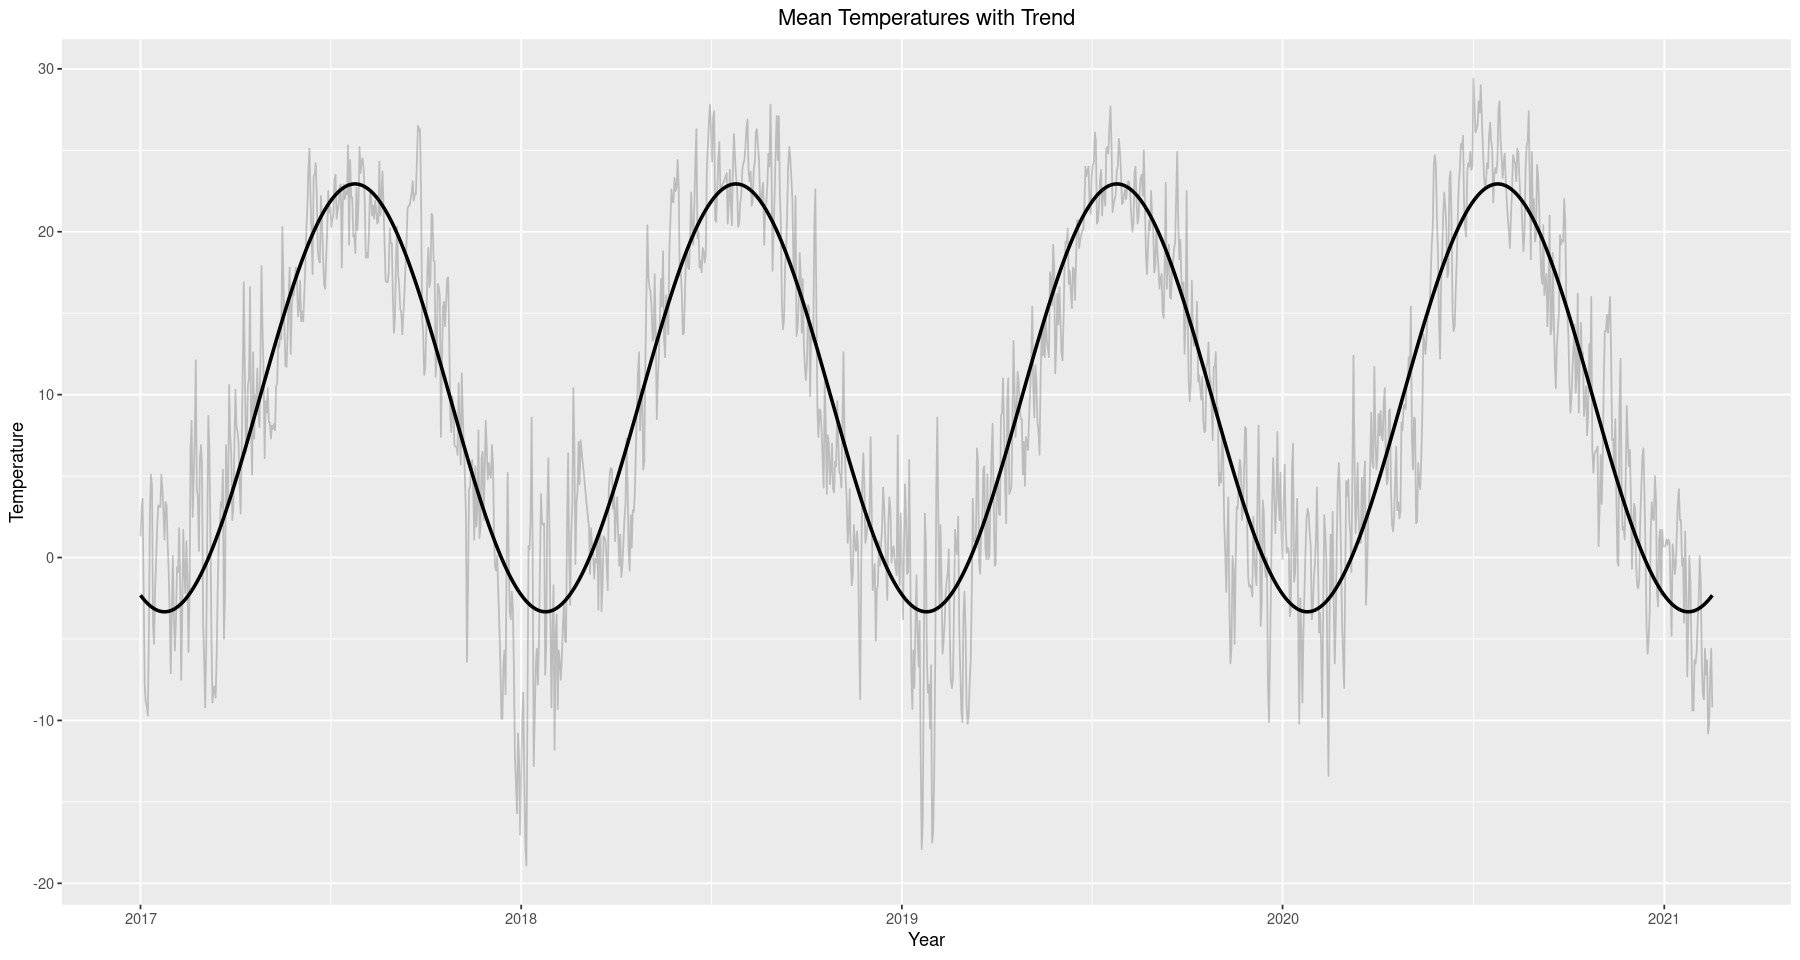

In [156]:
ggplot() + geom_line(data=train, aes(x=Date.Time, y=mean.temp), alpha=0.2) + 
        geom_line(data=train, aes(x=Date.Time, y=cos_model), size=1, color=1) +
        ggtitle('Mean Temperatures with Trend') + theme(plot.title = element_text(hjust = 0.5)) +
        xlab('Year') + ylab('Temperature')

Now that we have fitted a deterministic trend, we can proceed in extracting it and focusing on the residual noise.  Below is a plot of the original time series with the deterministic portion taken out.  We can use the ADF test like before to test nonstationarity, in which we get a significant result, hence we reject this null hypothesis in favor of the alternative; the data is stationary.  

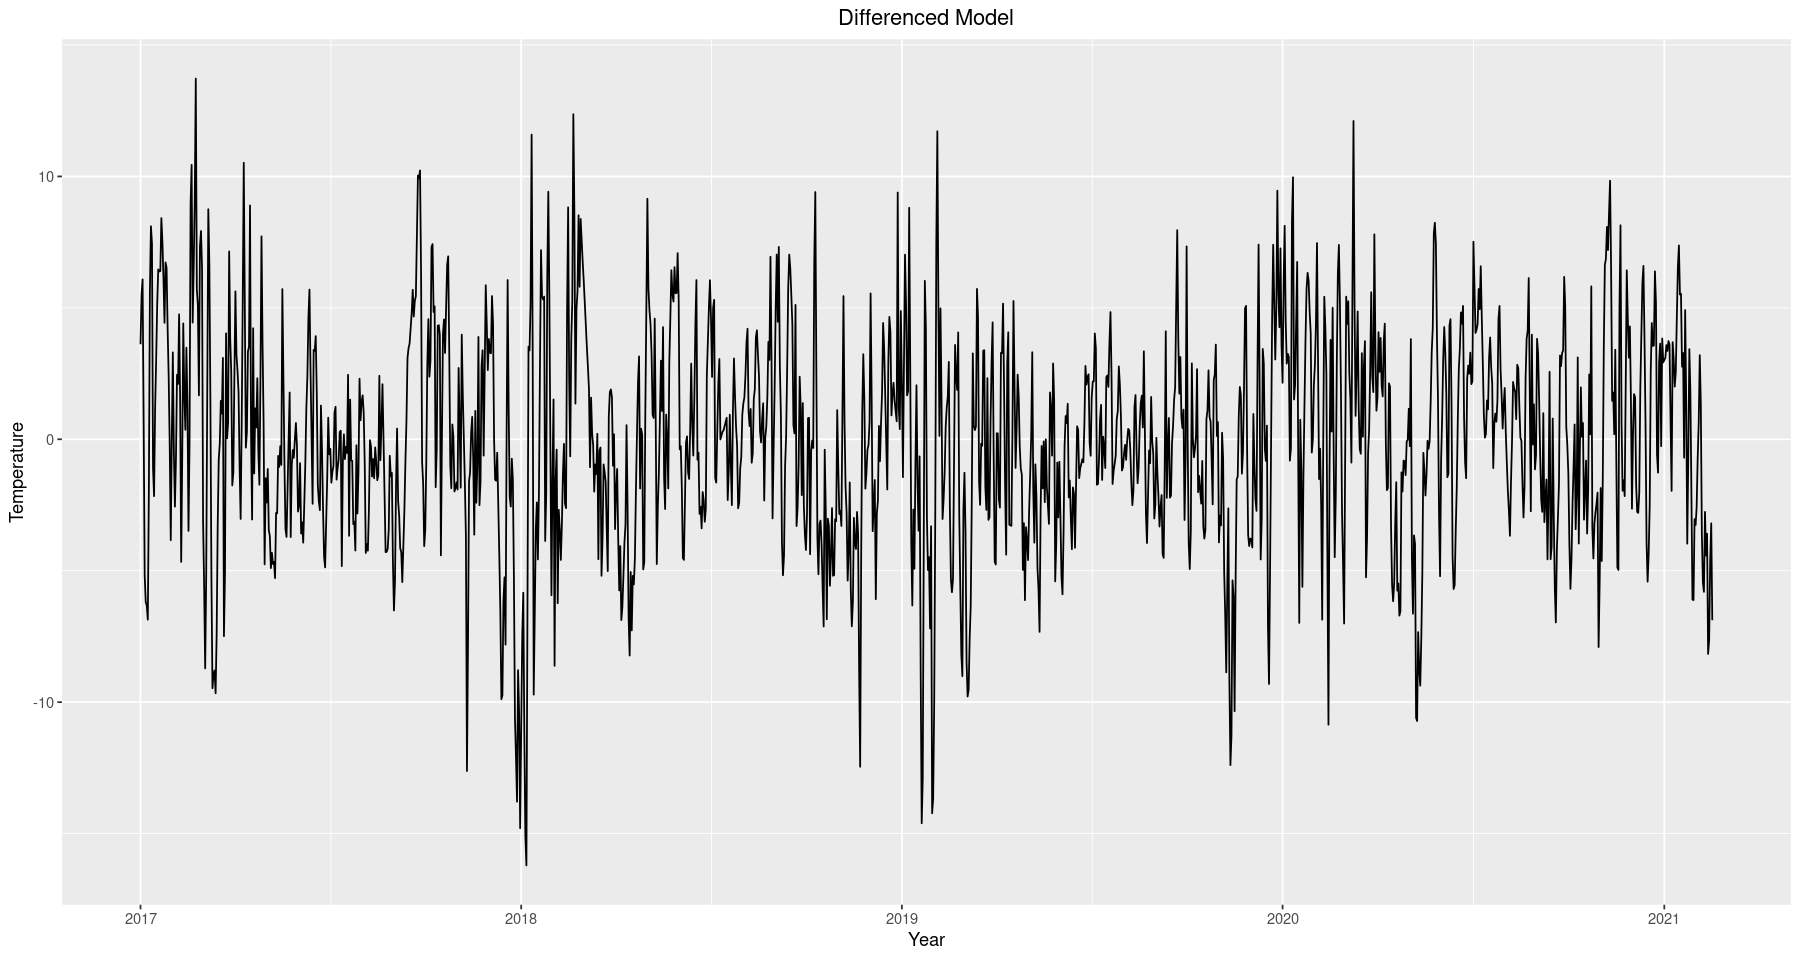

In [96]:
train$diff_model <- train[, 7] - train[, 8]
ggplot(data=train, aes(x=Date.Time, y=diff_model)) + geom_line() +
ggtitle('Differenced Model') + theme(plot.title = element_text(hjust = 0.5)) +
xlab('Year') + ylab('Temperature')

In [94]:
adf.test(train$diff_model)

Warning message in adf.test(train$diff_model):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  train$diff_model
Dickey-Fuller = -8.517, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Since we have a stationary time series we can apply the Box-Jenkins framework.  Our goal here is to fit an $ARMA(p,q)$ model and use our data to estimate $p$ and $q$.  The first place we start is with the ACF and PACF plots to get an idea of the nature of the data.  We see the ACF decay much quicker ut notice that it does not cut off distinctly anywhere; an strong indicator of an autoregressive component.  Likewise, the PACF cuts off at lag 3, indicating the order of the AR term could be 3.  However, since we are most likely looking at a mixed model, we will employ the extended ACF to indicate feasible models.

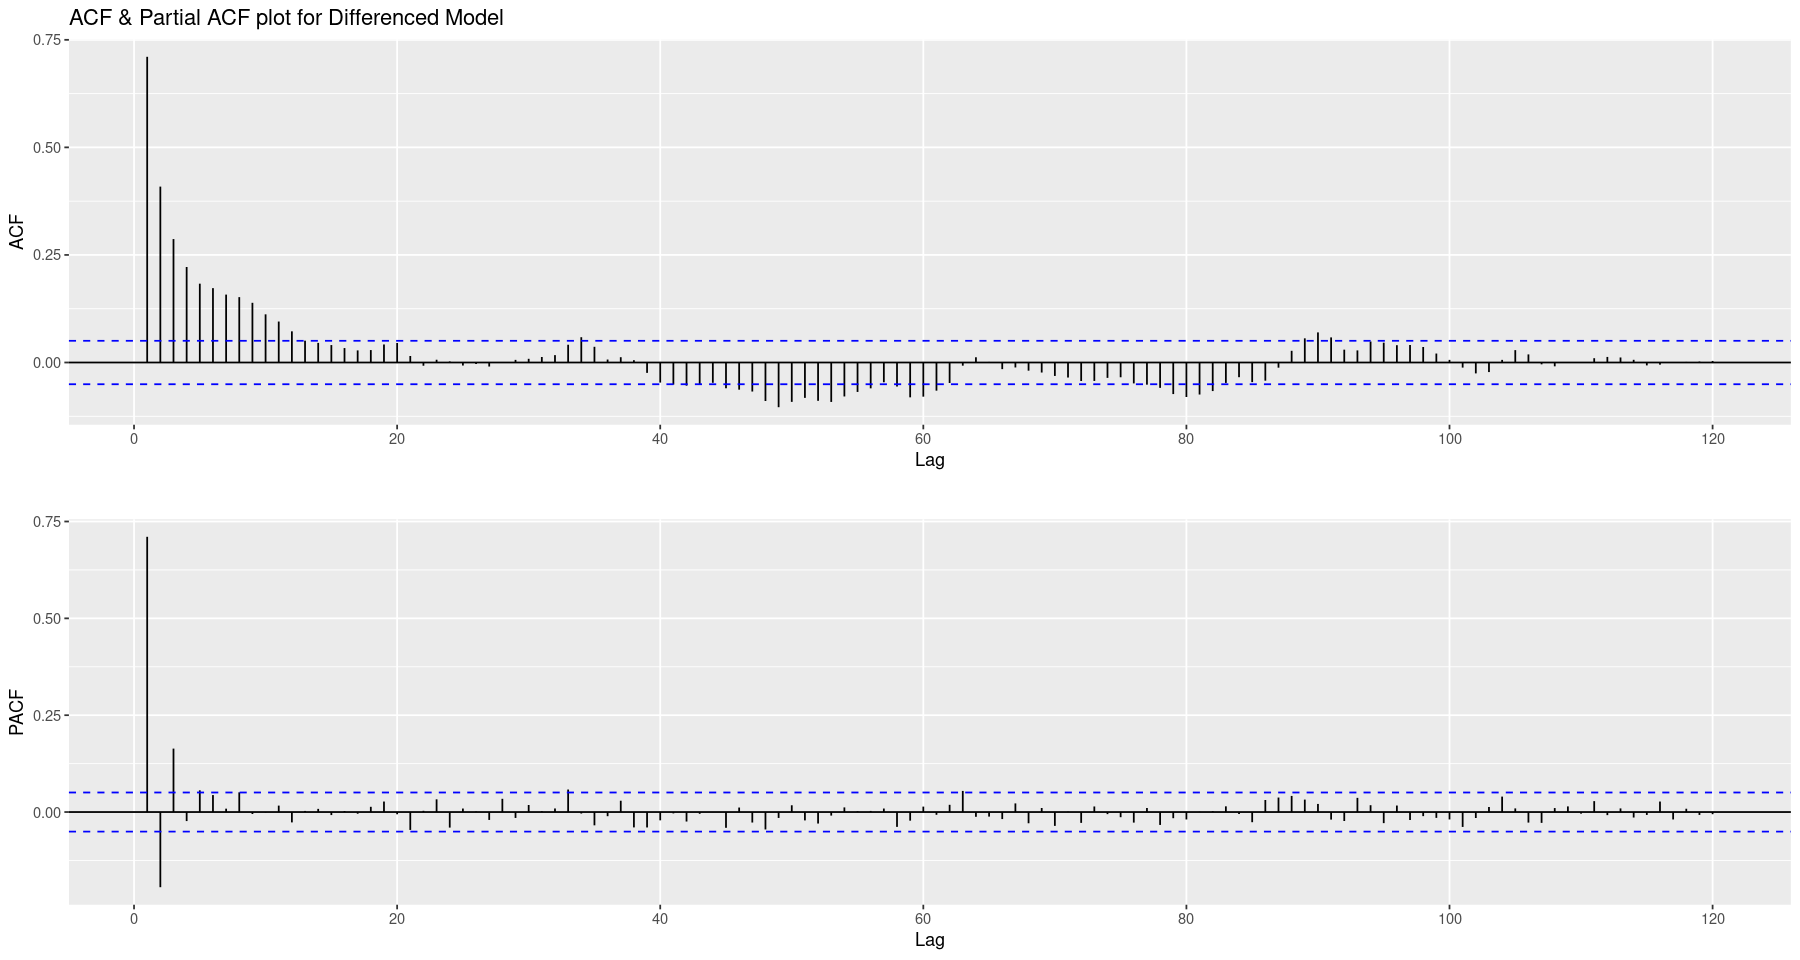

In [97]:
acf <- ggAcf(train$diff_model, lag.max=120) + ggtitle('ACF & Partial ACF plot for Differenced Model')
pacf <- ggPacf(train$diff_model, lag.max=120) + ggtitle('')
grid.arrange(acf, pacf, nrow=2)

In [99]:
eacf(train$diff_model, ar.max=5, ma.max=5)
# o is feasible
# x is not feasible

AR/MA
  0 1 2 3 4 5
0 x x x x x x
1 x x x o o o
2 x x o o o o
3 x x x o o o
4 x x x x o o
5 x x x x o o


Above we have a chart of the Extended ACF which indicates feasible models (o).  In the cell below we fit a collection of different models, record their AIC and BIC results and compare.  With both of these evaluation criterion we want to take a feasible model with the most favorible AIC and BIC results.  The diagnostics of each model were also compared, however are omitted because there is many of them.  Instead we elect to model using an $ARMA(3, 3)$ process and display its diagnostics below.  

In [100]:
# evaluate a collection of possible models
diff_model.aic <- matrix(0, 5, 5)
diff_model.bic <- matrix(0, 5, 5)
for (i in 0:4) for (j in 0:4){
    noise.fit <- arima(train$diff_model, order=c(i, 0, j), method="ML", include.mean = TRUE, optim.control = list(maxit=1000))
    diff_model.aic[i+1, j+1] <- noise.fit$aic
    diff_model.bic[i+1, j+1] <- BIC(noise.fit)
}

In [101]:
sort(unmatrix(diff_model.aic, byrow=FALSE))[1:10]
sort(unmatrix(diff_model.bic, byrow=FALSE))[1:10]

r3:c3    r2:c4    r3:c4    r2:c5    r4:c4    r5:c3    r5:c4    r5:c5 
7389.027 7389.961 7391.005 7391.605 7392.055 7392.871 7393.015 7393.167 
   r4:c5    r3:c5 
7393.586 7393.686

r3:c3    r4:c1    r2:c4    r2:c3    r2:c2    r3:c2    r4:c2    r5:c1 
7422.938 7423.530 7423.872 7424.136 7427.530 7429.085 7429.258 7430.040 
   r3:c4    r2:c5 
7430.234 7430.835

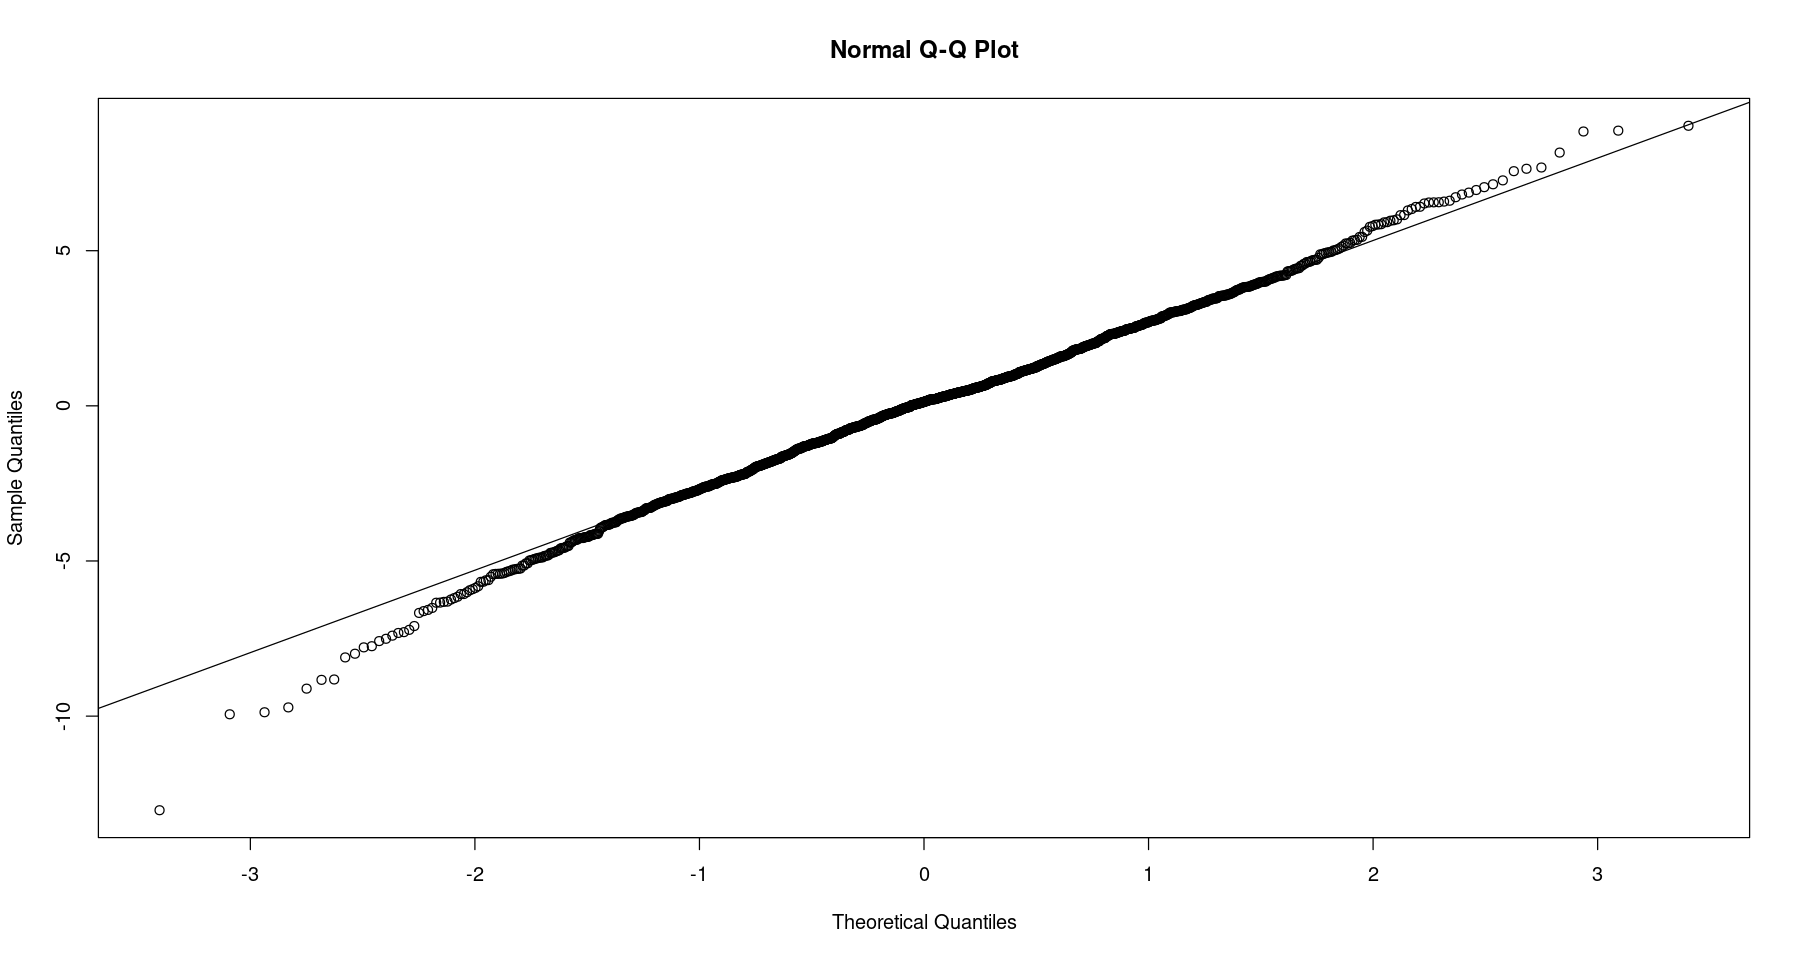

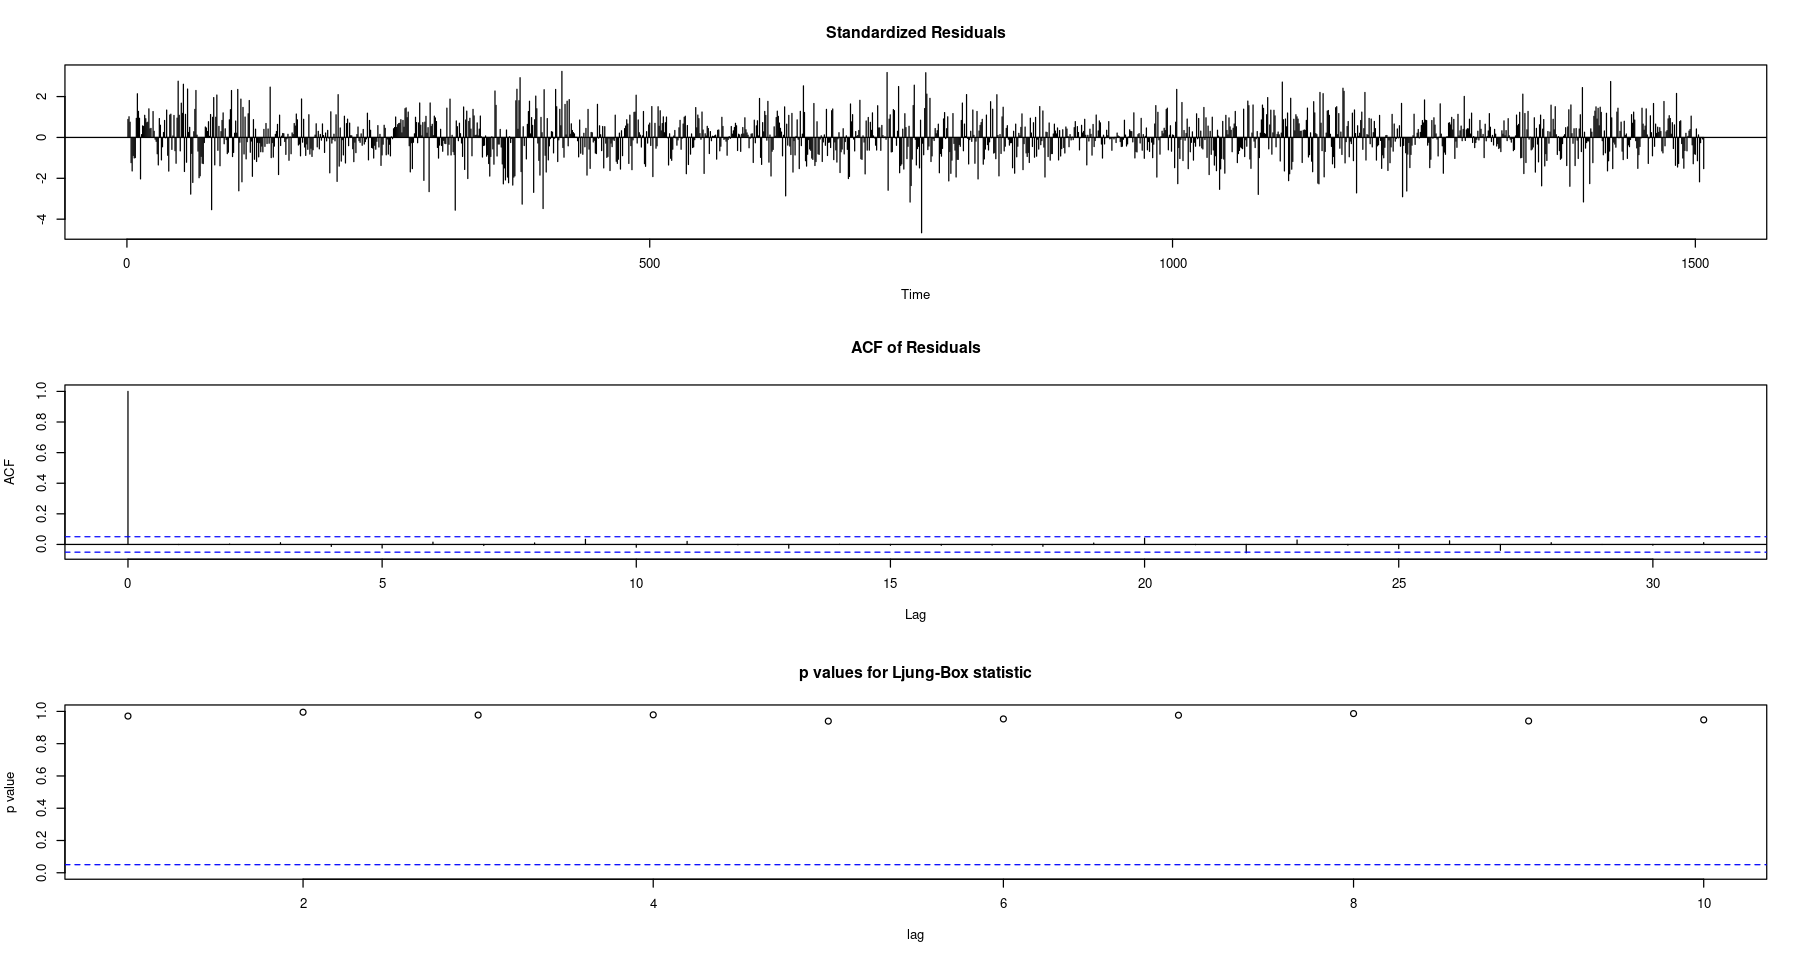

In [102]:
noise.fit <- arima(train$diff_model, order=c(3, 0, 3), method="ML", include.mean = TRUE)  # ARMA(3,3) model
model.res <- residuals(noise.fit)
qqnorm(model.res)
qqline(model.res)
tsdiag(model)

Near linearity between the theoretical and sample quantiles suggest that the errors are normally distributed.  The time plot of the residuals looks like a white noise process and the ACF does not indicate any significant lags, hence are uncorrelated.  We also have large p-values for the LB statistic, another strong indicator of uncorrelated errors.   

# 5. Forecasting
In this section we produce a forecast for 80 days and evaluate its performance relative to the actual observed data in the test set.  Forecasting is a relatively straight forward the requires extending both the deterministic and stochastic components and then recombining them.  Extending the deterministic cosine trend is performed by simp

In [33]:
# below we make use of time series object which requires we 
# specify the day of the year when the time series begins
test.day1 <- test[1, 1]
test.start.day <- as.numeric(strftime(test.day1, format = "%j")) 
s <- '{test.day1} is the {test.start.day}th day of the year'
print(glue(s))

2021-02-17 is the 48th day of the year


In [103]:
test.temps.ts <- ts(test$mean.temp, start=c(2020, test.start.day), f=365.25)
new_X <- harmonic(test.temps.ts, 1) # produce new set of predictor variables
pred_X <- data.frame(new_X)
colnames(pred_X) <- c("x1", "x2")
preds <- predict(cos_model, pred_X) # predict new vals for deterministic trend
test$cos_model <- preds # extended cosine curve
test <- test[, !(names(test) %in% c('cos_mode'))]

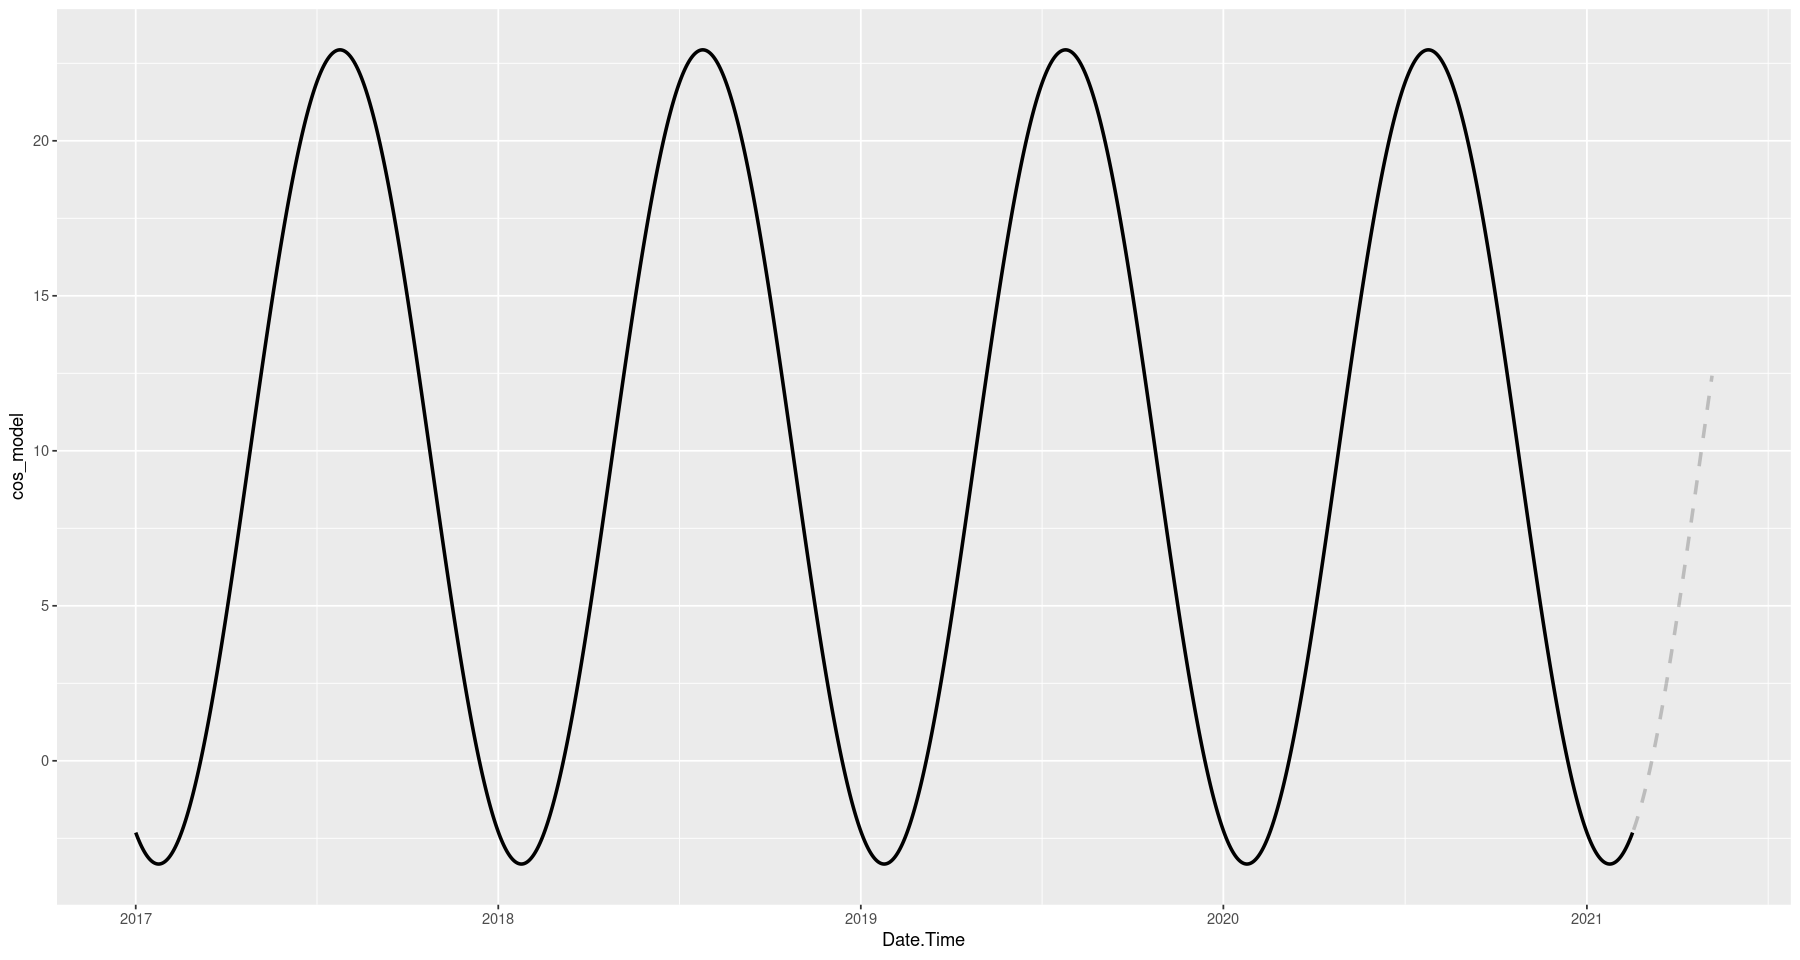

In [104]:
ggplot() + geom_line(data=train, aes(x=Date.Time, y=cos_model), size=1) + 
           geom_line(data=test, aes(x=Date.Time, y=cos_model), size=1, 
                                             alpha=0.2, linetype='dashed')

In [63]:
noise.forecast <- predict(noise.fit, 80) # 80 days out
# keep track of error bounds
p_se <- noise.forecast$pred + noise.forecast$se # forecast + (p) standard error (se)
m_se <- noise.forecast$pred - noise.forecast$se # forecast - (m) standard error (se)

In [66]:
forecast.temps <- noise.forecast$pred + c(preds)  # recovered forecasts (deterministic + noise)
forecast.p.e <- forecast.temps + noise.forecast$se      # upper (+) error bound
forecast.m.e <- forecast.temps - noise.forecast$se      # lower (-) error bound 

In [152]:
test$fc <- as.double(forecast.temps)
test$forecast.p.e <- as.double(forecast.p.e)
test$forecast.m.e <- as.double(forecast.m.e)

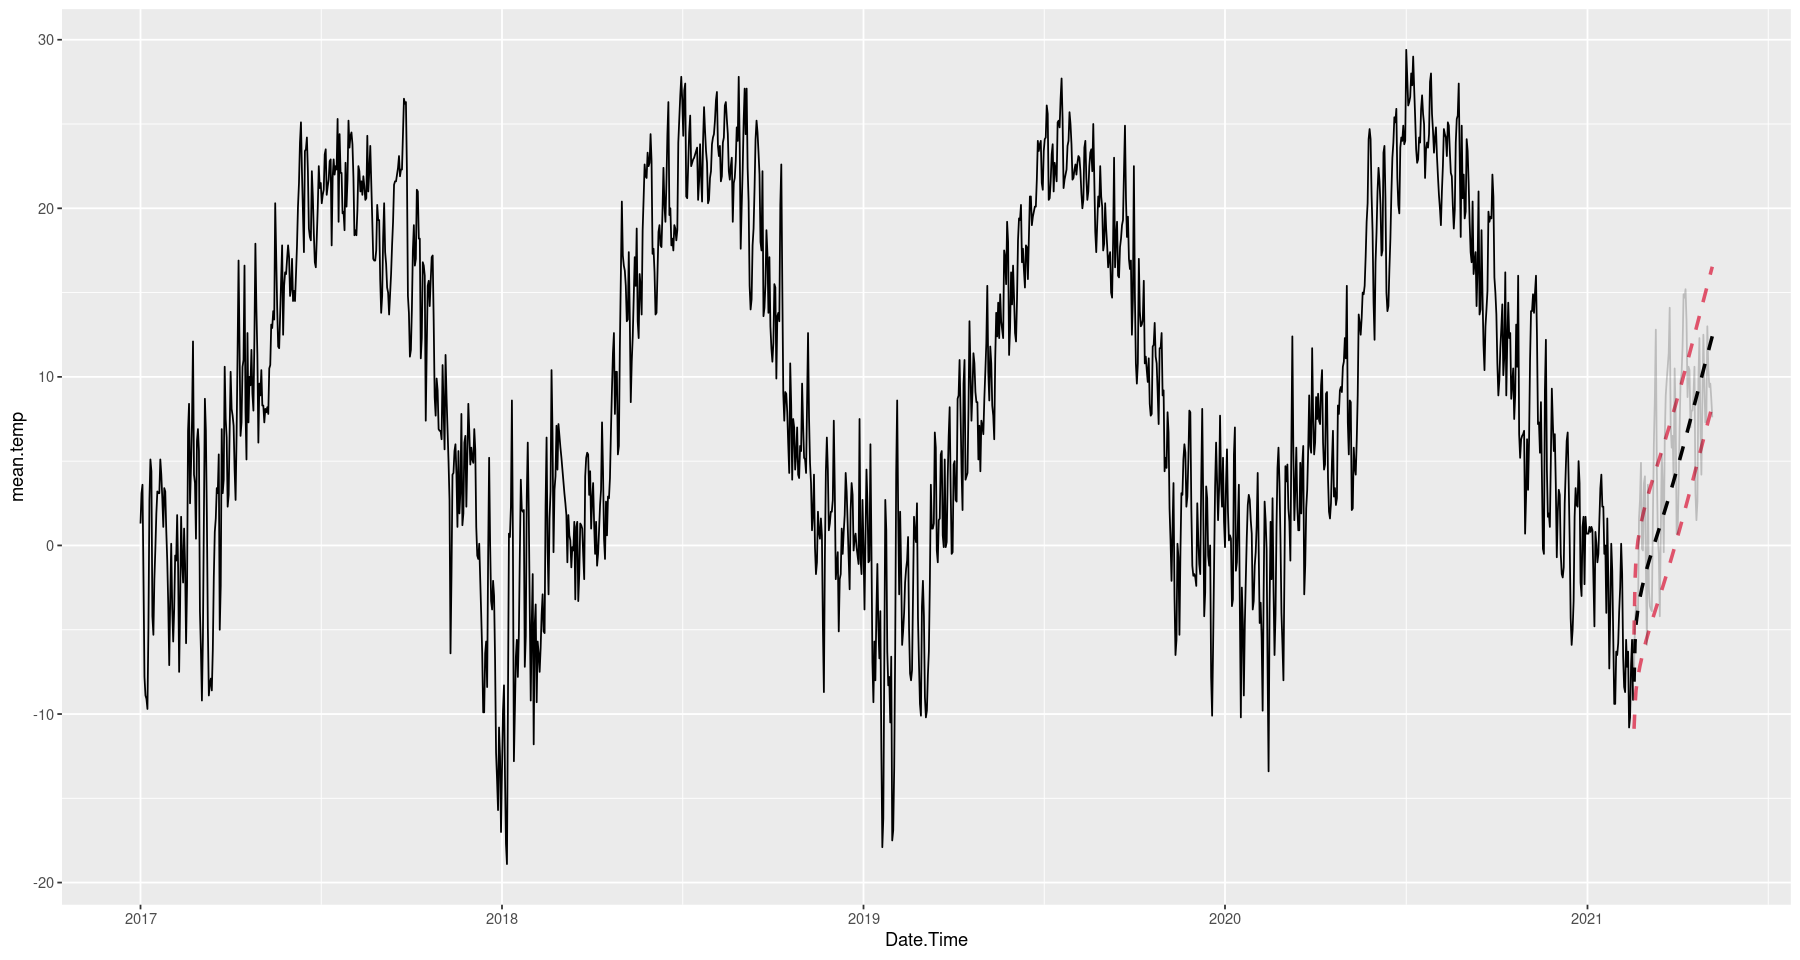

In [147]:
ggplot() + geom_line(data=train, aes(x=Date.Time, y=mean.temp)) + 
           geom_line(data=test, aes(x=Date.Time, y=fc), size=1, 
                                             alpha=1, linetype='dashed') +
           geom_line(data=test, aes(x=Date.Time, y=forecast.p.e), alpha=1, color=2, linetype='dashed', size=1) +
           geom_line(data=test, aes(x=Date.Time, y=forecast.m.e), alpha=1, color=2, linetype='dashed', size=1) +
           geom_line(data=test, aes(Date.Time, mean.temp), alpha=0.2)

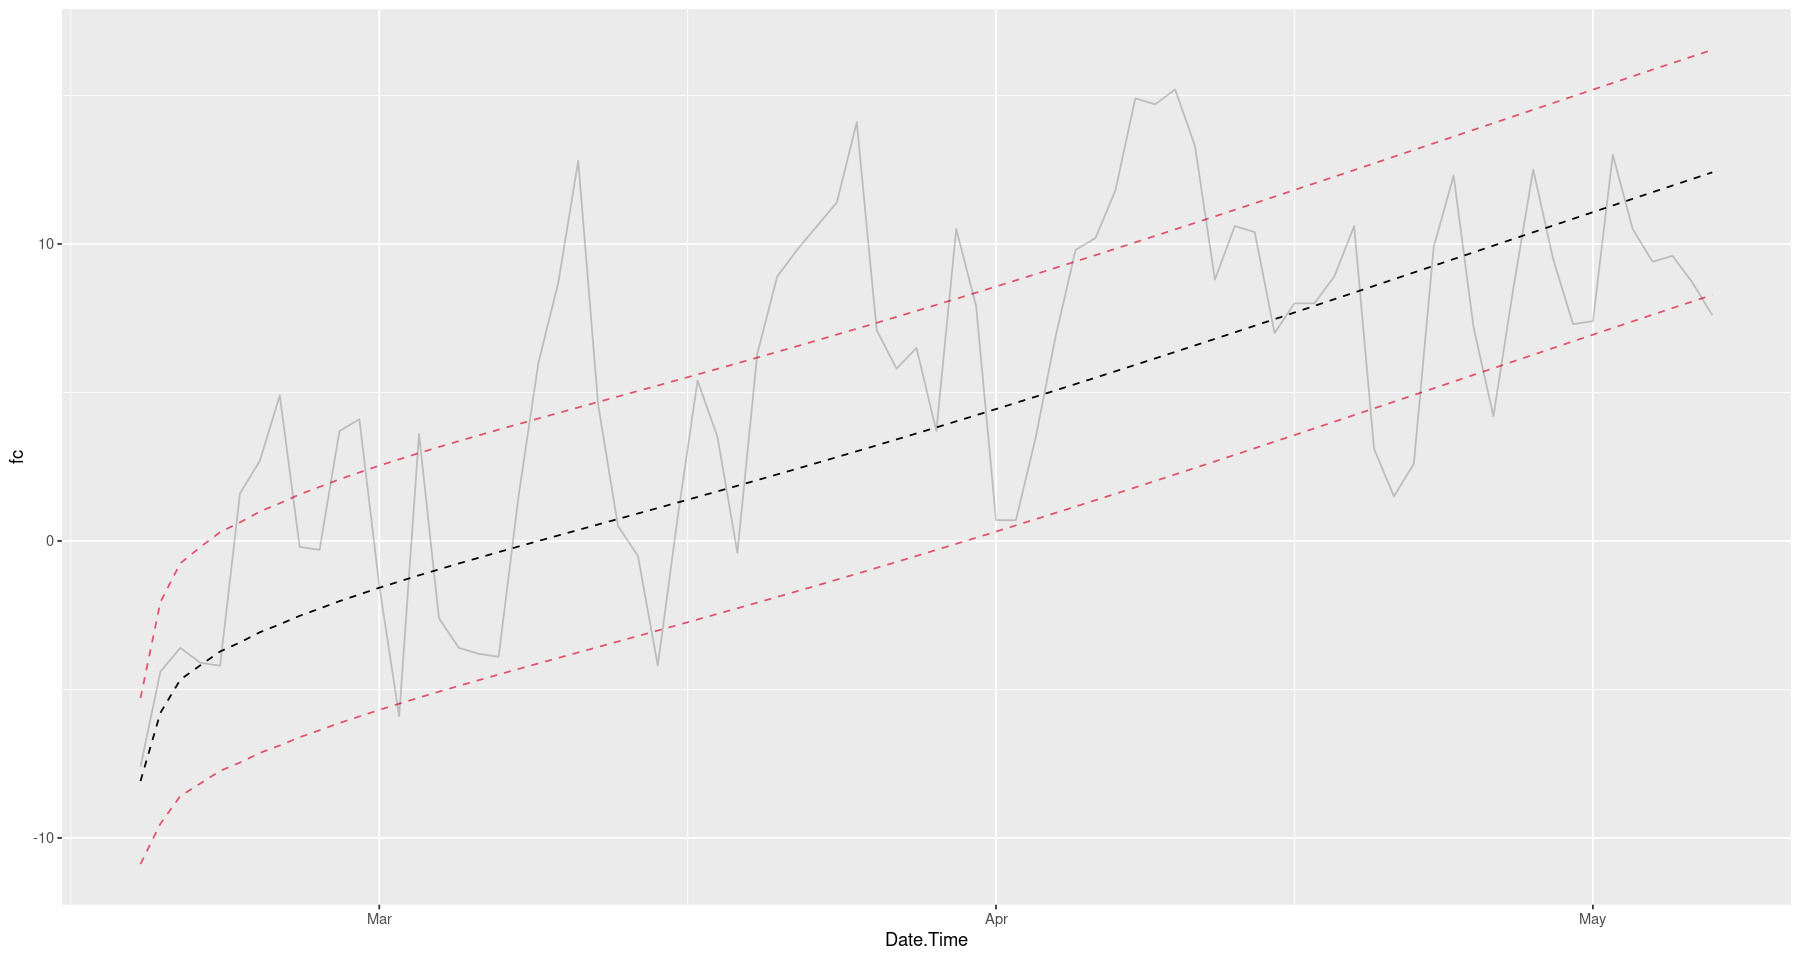

In [151]:
ggplot() + geom_line(data=test, aes(x=Date.Time, y=fc), linetype='dashed') + 
        geom_line(data=test, aes(x=Date.Time, y=forecast.p.e), color=2, linetype='dashed') + 
        geom_line(data=test, aes(x=Date.Time, y=forecast.m.e), color=2, linetype='dashed') +
        geom_line(data=test, aes(x=Date.Time, y=mean.temp), alpha=0.2) 

In [136]:
sqrt(sum(((test$mean.temp - test$fc)^2)) / nrow(test))  # Root Mean Square Error

[1] 4.682442